# Отток клиентов


Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling


### Описание данных

#### Признаки
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — количество недвижимости у клиента  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  

#### Целевой признак  
Exited — факт ухода клиента  


#### Часть 1. [Подготовка данных](#part1)
* [1. Импорт библиотек.](#part1.1)
* [2. Изучение данных](#part1.2)
* [3. Предобработка данных](#part1.3)
* [4. Прямое кодирование](#part1.4)
* [5. Масштабирование признаков](#part1.5)

#### Часть 2. [Исследование задачи](#part2)
* [1. Исследование дисбаланса классов](#part2.1)
* [2. Решающее дерево.](#part2.2)
* [3. Случайный лес](#part2.3)
* [4. Логистическая регрессия](#part2.4)

#### Часть 3. [Борьба с дисбалансом](#part3)
* [1. Сбалансированные веса классов.](#part3.1)  
    - [1. Решающее дерево.](#part3.1.1)  
    - [2. Случайный лес](#part3.1.2)  
    - [3. Логистическая регрессия](#part3.1.3)  
* [2. Увеличение выборки](#part3.2)
    - [1. Решающее дерево.](#part3.2.1)  
    - [2. Случайный лес](#part3.2.2)  
    - [3. Логистическая регрессия](#part3.2.3)  
* [3. Уменьшение выборки](#part3.3)
    - [1. Решающее дерево.](#part3.3.1)  
    - [2. Случайный лес](#part3.3.2)  
    - [3. Логистическая регрессия](#part3.3.3)
* [4. ROC-кривая выбранной модели](#part3.4) 

#### Часть 4. [Тестирование](#part4)

#### [Общий вывод](#part5)

<a id='part1'></a>
# 1. Подготовка данных
<a id='part1.1'></a>
## 1.1 Импорт библиотек

In [49]:
import warnings
warnings.filterwarnings("ignore", 
    message="FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_recall_curve

from sklearn.utils import shuffle

<a id='part1.2'></a>
## 1.2 Изучение данных

In [3]:
# Откроем и изучим датасет
data = pd.read_csv('/datasets/Churn.csv')
data.info()
display(data.head(15))
display(data['Geography'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


array(['France', 'Spain', 'Germany'], dtype=object)

В столбце количества недвижимости наблюдаются пропуски. Будем считать, что пропуск означает отсутствие недвижимости и заменим NaN на 0 и заменим тип данных на int.  
Для построения модели столбцы RowNumber, CustomerId и Surname не нужны, т.к. эти признаки уникальны для каждого клиента. Эти столбцы можно удалить.

Признаки Geography и Gender категориальные, их необходимо закодировать.

Признаки IsActiveMember, HasCrCard тоже категориальные, но уже закодированные.  

Признаки CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary - количественные, но имеют разный масштаб. Следовательно их необходимо масштабировать.

<a id='part1.3'></a>
## 1.3 Предобработка данных.

In [4]:
# Удаляем ненужные столбцы
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)
# Заполняем пропуски и переводим в int
data['Tenure']=data['Tenure'].fillna(0).astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


<a id='part1.4'></a>
## 1.4 Прямое кодирование

In [5]:
# Преобразуем датафрейм прямым кодированием
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.head(3))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0


<a id='part1.5'></a>
## 1.5 Масштабирование признаков

In [6]:
# Выделяем целевой признак
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

# Признаки, которые надо масштабировать
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','EstimatedSalary']

#Масштабируем признаки
scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])

display(features.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-0.817441,-1.225848,-0.911583,1,1,0.021886,0,0,0
1,-0.440036,0.198164,-1.138838,0.117350,-0.911583,0,1,0.216534,0,1,0
2,-1.536794,0.293517,1.110941,1.333053,2.527057,1,0,0.240687,0,0,0
3,0.501521,0.007457,-1.138838,-1.225848,0.807737,0,0,-0.108918,0,0,0
4,2.063884,0.388871,-0.817441,0.785728,-0.911583,1,1,-0.365276,0,1,0


### Вывод

Данные изучены и предварительно обработаны.

Удалены пропуски и ненужные столюцы, заменен тип данных. 

Категориальные признаки закодированы методом прямого кодирования.  

Количественные признаки масштабированы. 

<a id='part2'></a>
# 2. Исследование задачи
<a id='part2.1'></a>
## 2.1 Исследование дисбаланса классов

0    0.7963
1    0.2037
Name: Exited, dtype: float64


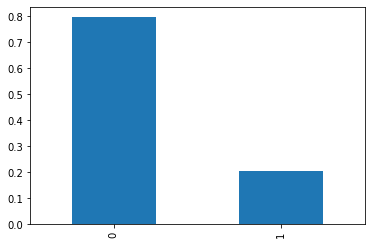

In [7]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Соотношение классов 1:4. Следовательно, классы несбалансированы, а значит метрику Accuracy использовать нельзя.

<a id='part2.2'></a>
## 2.2 Решающее дерево

In [8]:
# Разделим выборку на тренировочную и валидационную
#features_train, features_valid, target_train, target_valid = train_test_split(
#    features, target, test_size=0.25, random_state=1)

features_train_test, features_valid, target_train_test, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=1)
features_train,features_test, target_train, target_test = train_test_split(
    features_train_test, target_train_test, test_size=0.25, random_state=1)

model = DecisionTreeClassifier(random_state=1)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]

target_pred_constant = pd.Series([0 for i in range(len(features))])
print('Accuracy для константной модели:',accuracy_score(target, target_pred_constant))
print('Accuracy для решающего дерева:',accuracy_score(target_valid, predicted_valid))
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print('F1-мера:', f1_score(target_valid,predicted_valid))
print('Матрица ошибок')
print(confusion_matrix(target_valid,predicted_valid))



Accuracy для константной модели: 0.7963
Accuracy для решающего дерева: 0.7855
Auc Roc: 0.6698985215309186
F1-мера: 0.4774665042630938
Матрица ошибок
[[1375  210]
 [ 219  196]]


<a id='part2.3'></a>
## 2.3 Случайный лес

In [9]:
model = RandomForestClassifier(random_state=1)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]

print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print('F1-мера:', f1_score(target_valid,predicted_valid))
print('Матрица ошибок')
print(confusion_matrix(target_valid,predicted_valid))

Auc Roc: 0.8276644749344382
F1-мера: 0.5463258785942492
Матрица ошибок
[[1545   40]
 [ 244  171]]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<a id='part2.4'></a>
## 2.4 Логистическая регрессия

In [11]:
model = LogisticRegression(random_state=1)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]

print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print('F1-мера:', f1_score(target_valid,predicted_valid))
print('Матрица ошибок')
print(confusion_matrix(target_valid,predicted_valid))

Auc Roc: 0.7787830185093687
F1-мера: 0.3238434163701067
Матрица ошибок
[[1529   56]
 [ 324   91]]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Вывод
Наблюдается сильный дисбаланс классов с соотношением 1:4.

Accuracy на полученной модели практически равно Accuracy для константной модели.  
F1-мера решающего дерева сильно меньше требуемой (0.4981),  
F1-мера случайного леса также меньше требуемой (0.5769),  
F1-мера логистической регрессии сильно меньше требуемой (0.3224).  

Использование случайного леса уменьшает количество ложноположительных ответов.  
Использование логистической регрессии уменьшает количество ложноположительных ответов, но количество ложноотрицательных ответов.


<a id='part3'></a>
# 3. Борьба с дисбалансом
<a id='part3.1'></a>
## 3.1 Сбалансированные веса классов
<a id='part3.1.1'></a>
### 3.1.1 Решающее дерево

In [12]:
model = DecisionTreeClassifier(random_state=1,class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Auc Roc: 0.6941659382007526
F1: 0.5157384987893462


<a id='part3.1.2'></a>
### 3.1.2 Случайный лес

In [13]:
model = RandomForestClassifier(random_state=1,class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Auc Roc: 0.8273064497738589
F1: 0.5289514866979655


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<a id='part3.1.3'></a>
### 3.1.3 Логистическая регрессия

In [14]:
model = LogisticRegression(random_state=1, solver='liblinear',class_weight='balanced')
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Auc Roc: 0.783681350005701
F1: 0.5119574844995571


## Вывод:
При использовании сбалансированных весов классов больше всего улучшается F1-мера логистчической регрессии (0.5 против 0.32)  
F1-мера случайного леса практически не изменяется (уменьшилась на 0.008)  
F1-мера решающего дерева практически не изменяется (уменьшилась на 0.002)

<a id='part3.2'></a>
## 3.2 Увеличение выборки

Объекты "0" встречаются в 4 раза чаще, чем объекты "1".

In [15]:
def upsample(features,target,repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled)
    target_upsampled = shuffle(target_upsampled)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


<a id='part3.2.1'></a>
### 3.2.1 Решающее дерево

In [16]:
model = DecisionTreeClassifier(random_state=1)
model.fit(features_upsampled,target_upsampled)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Auc Roc: 0.5054175059860895
F1: 0.2812960235640648


<a id='part3.2.2'></a>
### 3.2.2 Случайный лес

In [17]:
model = RandomForestClassifier(random_state=1)
model.fit(features_upsampled,target_upsampled)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Auc Roc: 0.4732674546767512
F1: 0.27903579254930605


<a id='part3.2.3'></a>
### 3.2.3 Логистическая регрессия

In [18]:
model = LogisticRegression(random_state=1)
model.fit(features_upsampled,target_upsampled)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Auc Roc: 0.4533571510014823
F1: 0.28266331658291455


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Вывод:
Увеличение количества положительных объектов не помогает улучшить качество моделей.

<a id='part3.3'></a>
## 3.3 Уменьшение выборки

In [73]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

<a id='part3.3.1'></a>
### 3.3.1 Решающее дерево

In [74]:
model = DecisionTreeClassifier(random_state=1)
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Auc Roc: 0.7081524837520428
F1: 0.5103189493433395


<a id='part3.3.2'></a>
### 3.3.2 Случайный лес

In [75]:
model = RandomForestClassifier(random_state=1)
model.fit(features_downsampled,target_downsampled)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Auc Roc: 0.845857626087948
F1: 0.6229508196721312


<a id='part3.3.3'></a>
### 3.3.3 Логистическая регрессия

In [76]:
model = LogisticRegression(random_state=1, solver='liblinear')
model.fit(features_downsampled,target_downsampled)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Auc Roc: 0.783307361939873
F1: 0.5073280721533258


Уменьшение количества отрицательных объектов помогло улучшить результат.

F1-мера для решающего дерева равна 0.495  
F1-мера для случайного леса равна 0.599  
F1-мера для логистической регрессии равна 0.512  

Таким образом, для получения F1-меры выше 0.59 необходимо использовать модель случайного леса с исправлением дисбаланса классов методом уменьшения выборки.

<a id='part3.4'></a>
## 3.4 Подбор параметров выбранной модели

In [77]:
model = RandomForestClassifier(random_state=1)

depth =   [i for i in range(1,20)]
estim = [i for i in range(10,200,10)]

ran_for_params = {'max_depth': depth, 'n_estimators':estim }

grid = GridSearchCV(model,ran_for_params,scoring='f1',n_jobs=1)
grid.fit(features_downsampled,target_downsampled)
print('Лучшие параметры модели RandomForestClassifier:')
display(grid.best_params_)
print('F1: ',grid.best_score_)

Лучшие параметры модели RandomForestClassifier:


{'max_depth': 16, 'n_estimators': 110}

F1:  0.7131349044450885


<a id='part3.5'></a>
## 3.5 ROC-кривая выбранной модели

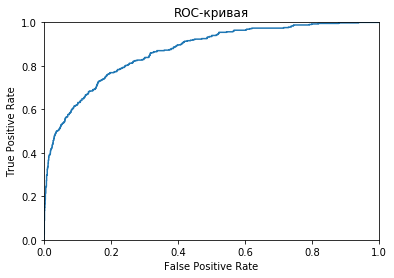

Auc Roc: 0.8684436167382462
F1: 0.619324796274738


In [80]:
model = RandomForestClassifier(random_state=1, max_depth=14,n_estimators=150)
model.fit(features_downsampled,target_downsampled)

predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()

plt.plot(fpr, tpr, linestyle='-')

plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()

print("Auc Roc:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Полученная ROC-кривая показывает, что качество полученной модели хорошее, TPR высокий.

## Вывод:

Для получения F1-меры выше 0.59 была использована модель случайного леса с исправлением дисбаланса классов методом уменьшения выборки.  

Методом GridSearchCV были подобраны наилучшие гиперпараметры:  
max_depth = 16, n_estimators = 110

F1-мера на тренировочной выборке: 0.713  
F1-мера на валидационной выборке: 0.619  


<a id='part4'></a>
# 4. Тестирование

In [81]:
predicted_test = model.predict(features_test)

probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
probabilities_one_test = model.predict_proba(features_test)[:, 1]

print("Auc Roc валидационная:", roc_auc_score(target_valid,probabilities_one_valid))
print("F1 валидационная:", f1_score(target_valid, predicted_valid))

print("Auc Roc тестовая:", roc_auc_score(target_test,probabilities_one_test))
print("F1 тестовая:", f1_score(target_test, predicted_test))

Auc Roc валидационная: 0.8684436167382462
F1 валидационная: 0.619324796274738
Auc Roc тестовая: 0.8331154270077153
F1 тестовая: 0.5905420991926182


<a id='part5'></a>
# Общий вывод

В результате работы были обработаны и подготовлены данные:
* Удалены пропуски и ненужные столюцы, заменен тип данных
* Категориальные признаки закодированы методом прямого кодирования
* Количественные признаки масштабированы

Были изучены метрики (AUC-ROC, F1-мера и матрица ошибок) различных моделей без учета дисбаланса.

Был учтен дисбаланс, подобрана лучшая модель и методика учета дисбаланса. Проведен поиск лучших гиперпараметров.  
Выбранная модель была проверена на тестовой выборке.  

F1-мера на тренировочной выборке: 0.713  
F1-мера на валидационной выборке: 0.619  
F1-мера на тестовой выборке: 0.5905